# Multilayer Perceptron (Pytorch) - Two spiral Dataset

Next we will look at a more complex classification task. The two spiral dataset consists of (x,y) coordinates of two alternating spirals, as can be seen in the following image. The aim of this exercise is to train a multilayer perceptron (MLP) to correctly classify an (x,y) coordinate.
Most parts of the code is borrowed from the following address:

###### https://github.com/Formulator/Spiral/blob/master/PyTorch_Spiral_DataLoader.ipynb


In this example, we will generate the dataset. But, instead of generating the dataset, we can read it from a file that takes the following form:

|    x   |    y   | class |
|:------:|:------:|:-----:|
|  -6.5  |   0.0  |   0   |
|  -6.5  |  -0.0  |   1   |
|  6.314 |  1.256 |   0   |
| -6.314 | -1.256 |   1   |
|   ...  |   ...  |  ...  |

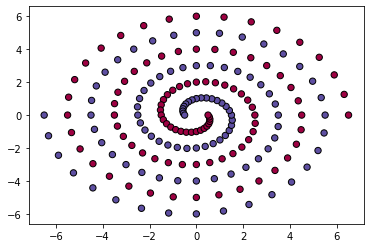

In [19]:
#%% Create and plot the data.....

# A bit of setup
import csv
import numpy as np
from numpy import arange, round, meshgrid, resize
import matplotlib.pyplot as plt
import torch
import os
from os import path
from torch.utils import data
import torch.nn as nn
from torch.utils import data
import time

#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'


def read_two_spiral_file(filename="datasets/spiralsdataset.csv"):
    x = []
    y = []
    
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file)
        for row in csv_reader:
            x.append(list(map(float, row[:-1])))
            y.append([int(v) for v in row[-1:]])

    return np.array(x), np.array(y)

x, y = read_two_spiral_file()

plt.scatter(x[:, 0], x[:, 1], edgecolors='k', c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

Now, we can define a function that can use GPUs if there were any available.

In [20]:
#GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 0:
    print("Running on : ", torch.cuda.device_count(), " GPUs!"
          if torch.cuda.device_count() > 1 else " GPU!")
else:
    print("Running on CPU!")

Running on CPU!


In [21]:
# Prepare folder (Just make a folder in the current working directory)

# create the data directory
print('Current working directory: ', os.getcwd())
if os.path.exists('data'):
  import shutil
  shutil.rmtree('data')
  print('Removed previously created data directory & contents') 

os.mkdir('data')
print('New data directory created')

print(os.listdir())

Current working directory:  /Users/minnieb/Notebooks/Week02_Notebooks_PyTorch
Removed previously created data directory & contents
New data directory created
['06_Pytorch_two_spiral_dataset.ipynb', '.DS_Store', 'nn.png', '05_Pytorch_perceptron_N-bit_parity_dataset.ipynb', '04_Pytorch_perceptron_XOR_dataset.ipynb', 'spiral_linear.png', 'datasets', 'two_spiral.png', '.ipynb_checkpoints', 'nn_3bit.png', 'data', '03_Pytorch_perceptron_AND_dataset.ipynb']


Now, we serialise the PyTorch tensors to the disk. 

In [22]:
# Join class labels vector onto features matrix ready for storage
Xy = np.block([[x, y]])

# Method to store each sample under an enumerated file name
def store_as_torch_tensor(slc, num):
  pt_array = torch.tensor(slc, dtype=torch.float)
  torch.save(pt_array, 'data/id-{}.pt'.format(num))
  #print(slc.size, 'data/id-{}.pt'.format(num), pt_array)
  return num + 1

# Commence file name enumeration with.... 
ID = 1

# Save to disk
for row in Xy:
  ID = store_as_torch_tensor(row, ID)

It's time to prepare the dataloader source and divide the data to two parts.

In [23]:
#%% Prepare DataLoader sources 
from random import shuffle

# Working with file NAMES of each sample
samples = []
# Walk the 'data' directory
for (dirpath, dirnames, filenames) in os.walk('data'):
  samples = filenames
  
# Shuffle before splitting
shuffle(samples)

# Split dataset by percentage
train = samples[0 : int(len(samples) * .75)]
valid = samples[int(len(samples) * .75) : ]
print('Training   set: ', len(train))  
print('Validation set: ', len(valid))

# Assign sample NAMES to partition dictionary
partition = {'train': train, 'validation' : valid}
#print(partition)

# Assign label VALUES to labels dictionary
labels = {}
for sample in samples:
  sample_tensor = torch.load('data/' + sample)
  labels[sample] = int(sample_tensor[-1].item())

Training   set:  145
Validation set:  49


In Pytorch, for specific data, we should write a custom dataset class to prepare the desire data for dataloader.

In [24]:
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        # From file load the data for this sample
        X = torch.load('data/' + ID)
        # Slice off the labels column so that only features are assigned to X
        X = X[:-1]
        # Labels dictionary was loaded into memory earlier; here the
        # file name is used as the key to retrieve the class label value
        y = torch.tensor(self.labels[ID])
        # Apply one-hot encoding to the class label
        y_ohe = torch.nn.functional.one_hot(y , num_classes=3).float()
        
        return X, y_ohe

In [25]:
def check_accuracy(model, x_data, y_data):
  X_check = x_data.to(device).clone().detach()
  y_check = y_data.to(device).clone().detach()
  
  #Set model to evaluation mode
  model.eval()
  
  #Make predictions
  predictions = model(X_check)
  ''' max_vals is a tensor of probability values.
      arg_maxs is a tensor of the index locations at which
      the maximum probability occured in the tensor.'''
  
  (max_vals, arg_maxs) = torch.max(predictions.data, dim=1)
  (y_max_vals, y_arg_maxs) = torch.max(y_check.data, dim=1)
  
  # arg_maxs is tensor of indices [0, 1, 0, 2, 1, 1 . . ]
  num_correct = torch.sum(y_arg_maxs == arg_maxs)
  acc = (num_correct * 100.0 / len(y_data))
  return acc.item()


def plot_decision_boundary(network, features, labels):
  # Plot the decision boundary
  # Determine grid range in x and y directions
  x_min, x_max = features[:, 0].min()-1, features[:, 0].max()+1
  y_min, y_max = features[:, 1].min()-1, features[:, 1].max()+1

  # Set grid spacing parameter
  spacing = min(x_max - x_min, y_max - y_min) / 250

  # Create grid
  XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
               np.arange(y_min, y_max, spacing))

  # Concatenate data to match input
  data = np.hstack((XX.ravel().reshape(-1,1), 
                  YY.ravel().reshape(-1,1)))

  # Pass data to predict method
  data_t = torch.tensor(data, dtype=torch.float).to(device)
  #Set model to evaluation mode
  model.eval()
  Z = model(data_t)

  #Convert PyTorch tensor to NumPy for plotting.
  Z = np.argmax(Z.detach().cpu().numpy(), axis=1)
  Z = Z.reshape(XX.shape)
  fig = plt.figure()
  plt.contourf(XX, YY, Z, cmap=plt.cm.Spectral, alpha=0.8)
  plt.scatter(features[:, 0], features[:, 1], edgecolors='k', c=labels, s=40, cmap=plt.cm.Spectral)
  plt.xlim(XX.min(), XX.max())
  plt.ylim(YY.min(), YY.max())
  fig.savefig('spiral_linear.png')
  plt.show()

Define the Neural Network architecture, loss function and optimizer.

In [26]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_inputs, num_classes, dropout_prob=0.3):
        super(NeuralNetwork, self).__init__()
        self.pipe = nn.Sequential(
            nn.Linear(num_inputs, 12),
            nn.ReLU(),
            nn.Linear(12, 9),
            nn.ReLU(),
            nn.Linear(9, 6),
            nn.ReLU(),
            nn.Linear(6, num_classes),
            nn.Dropout(p=dropout_prob),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.pipe(x)
    
loss_fn = torch.nn.MSELoss(reduction='mean')

# Weight initialisation function
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Instantiate the model
model = NeuralNetwork(2, 3)

# Move network to our selected device
model.to(device)

# Initialise weights
model.apply(init_weights)

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update, weight_decay applies L2
# regularization to smooth the weights.
learning_rate = 1e-2
lambda_L2 = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=lambda_L2)

Training loop using Dataloader

---------- Epoch: 10 ----------
Accuracy: Training Set  : 55.86%
Accuracy: Validation Set: 34.69%


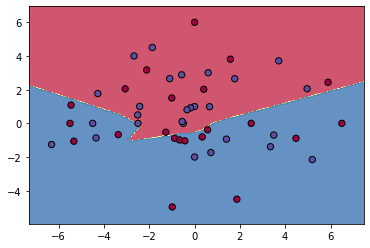

---------- Epoch: 20 ----------
Accuracy: Training Set  : 55.86%
Accuracy: Validation Set: 46.94%


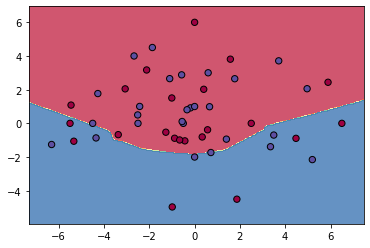

---------- Epoch: 30 ----------
Accuracy: Training Set  : 57.93%
Accuracy: Validation Set: 38.78%


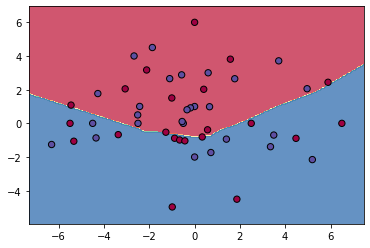

---------- Epoch: 40 ----------
Accuracy: Training Set  : 55.17%
Accuracy: Validation Set: 42.86%


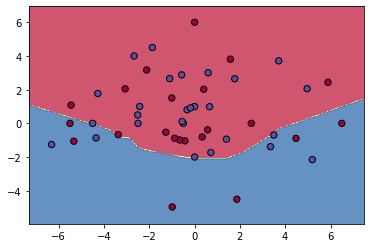

---------- Epoch: 50 ----------
Accuracy: Training Set  : 57.93%
Accuracy: Validation Set: 46.94%


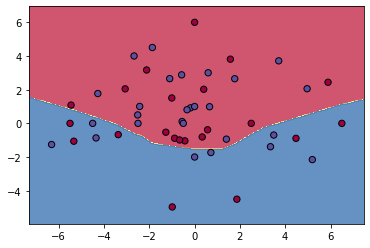

---------- Epoch: 60 ----------
Accuracy: Training Set  : 58.62%
Accuracy: Validation Set: 44.90%


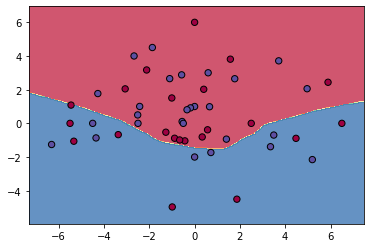

---------- Epoch: 70 ----------
Accuracy: Training Set  : 57.93%
Accuracy: Validation Set: 38.78%


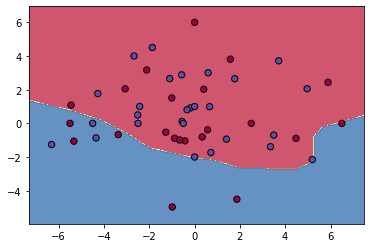

---------- Epoch: 80 ----------
Accuracy: Training Set  : 56.55%
Accuracy: Validation Set: 44.90%


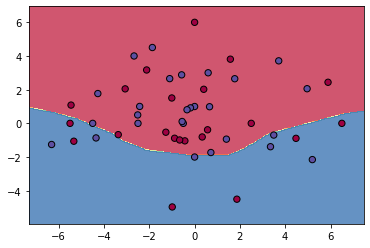

---------- Epoch: 90 ----------
Accuracy: Training Set  : 60.00%
Accuracy: Validation Set: 38.78%


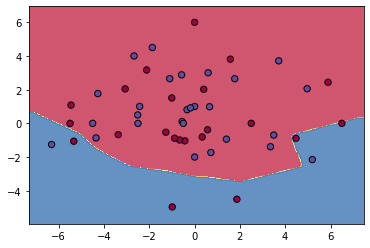

---------- Epoch: 100 ----------
Accuracy: Training Set  : 55.17%
Accuracy: Validation Set: 42.86%


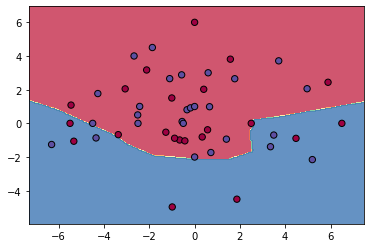

---------- Epoch: 110 ----------
Accuracy: Training Set  : 55.86%
Accuracy: Validation Set: 42.86%


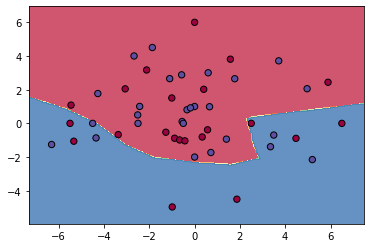

---------- Epoch: 120 ----------
Accuracy: Training Set  : 57.93%
Accuracy: Validation Set: 42.86%


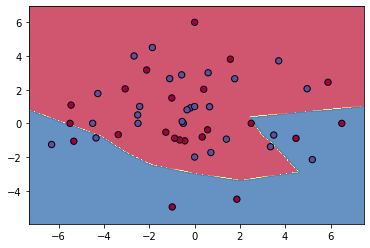

---------- Epoch: 130 ----------
Accuracy: Training Set  : 57.93%
Accuracy: Validation Set: 44.90%


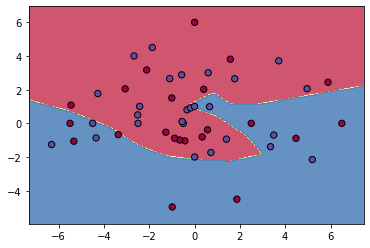

---------- Epoch: 140 ----------
Accuracy: Training Set  : 57.93%
Accuracy: Validation Set: 44.90%


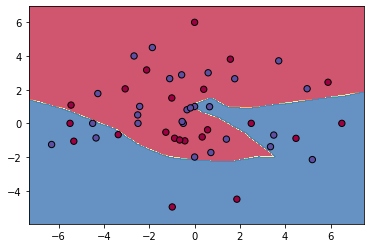

---------- Epoch: 150 ----------
Accuracy: Training Set  : 53.79%
Accuracy: Validation Set: 44.90%


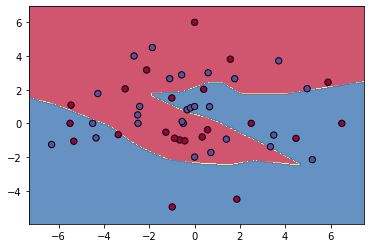

---------- Epoch: 160 ----------
Accuracy: Training Set  : 59.31%
Accuracy: Validation Set: 51.02%


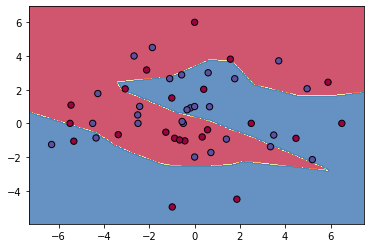

---------- Epoch: 170 ----------
Accuracy: Training Set  : 60.00%
Accuracy: Validation Set: 46.94%


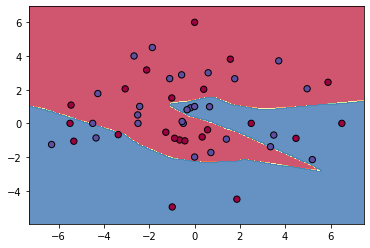

---------- Epoch: 180 ----------
Accuracy: Training Set  : 60.69%
Accuracy: Validation Set: 40.82%


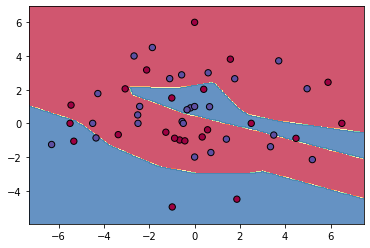

---------- Epoch: 190 ----------
Accuracy: Training Set  : 53.79%
Accuracy: Validation Set: 42.86%


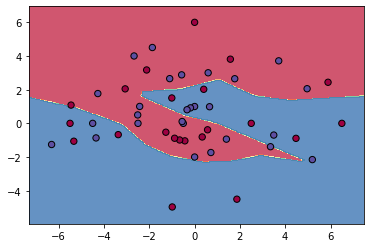

---------- Epoch: 200 ----------
Accuracy: Training Set  : 62.76%
Accuracy: Validation Set: 48.98%


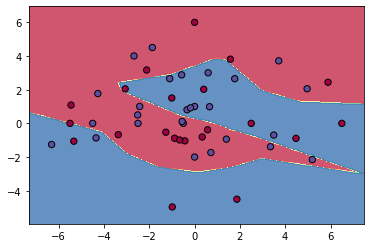

---------- Epoch: 210 ----------
Accuracy: Training Set  : 55.86%
Accuracy: Validation Set: 40.82%


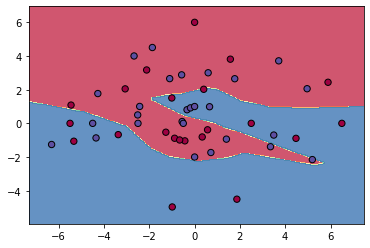

---------- Epoch: 220 ----------
Accuracy: Training Set  : 58.62%
Accuracy: Validation Set: 40.82%


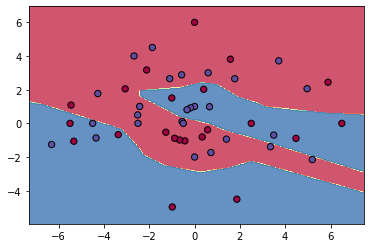

---------- Epoch: 230 ----------
Accuracy: Training Set  : 65.52%
Accuracy: Validation Set: 42.86%


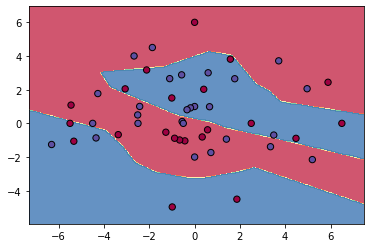

---------- Epoch: 240 ----------
Accuracy: Training Set  : 55.86%
Accuracy: Validation Set: 40.82%


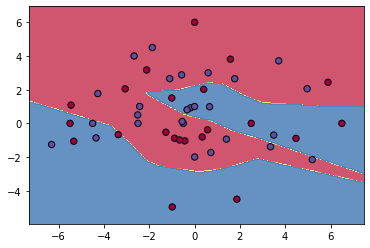

---------- Epoch: 250 ----------
Accuracy: Training Set  : 61.38%
Accuracy: Validation Set: 40.82%


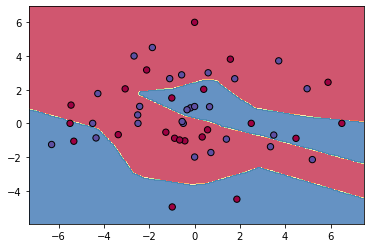

---------- Epoch: 260 ----------
Accuracy: Training Set  : 61.38%
Accuracy: Validation Set: 38.78%


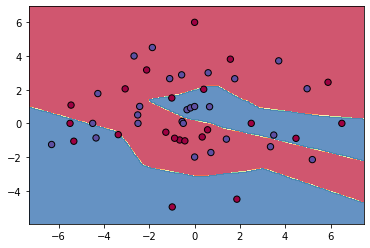

---------- Epoch: 270 ----------
Accuracy: Training Set  : 64.14%
Accuracy: Validation Set: 42.86%


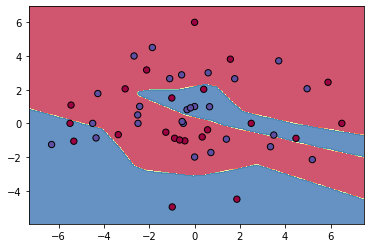

---------- Epoch: 280 ----------
Accuracy: Training Set  : 62.76%
Accuracy: Validation Set: 42.86%


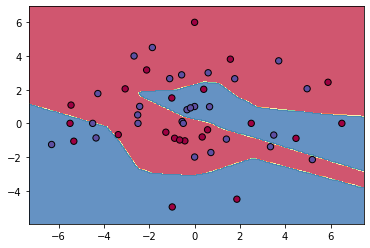

---------- Epoch: 290 ----------
Accuracy: Training Set  : 63.45%
Accuracy: Validation Set: 42.86%


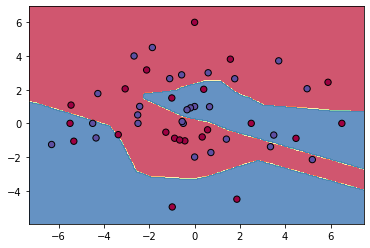

---------- Epoch: 300 ----------
Accuracy: Training Set  : 62.76%
Accuracy: Validation Set: 42.86%


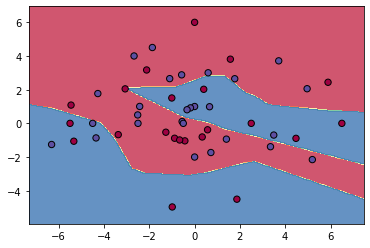

---------- Epoch: 310 ----------
Accuracy: Training Set  : 57.24%
Accuracy: Validation Set: 40.82%


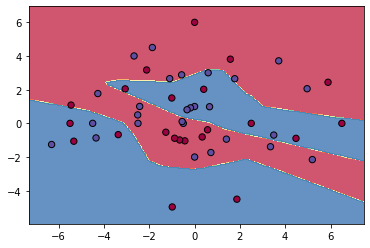

---------- Epoch: 320 ----------
Accuracy: Training Set  : 62.07%
Accuracy: Validation Set: 38.78%


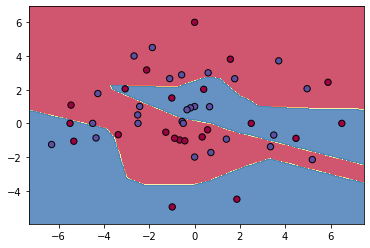

---------- Epoch: 330 ----------
Accuracy: Training Set  : 55.86%
Accuracy: Validation Set: 40.82%


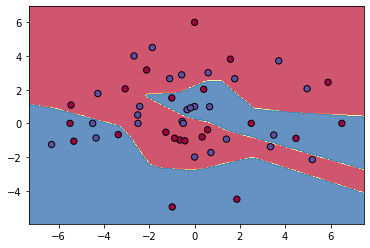

---------- Epoch: 340 ----------
Accuracy: Training Set  : 56.55%
Accuracy: Validation Set: 40.82%


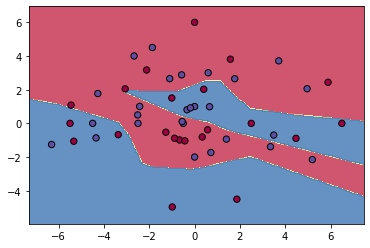

---------- Epoch: 350 ----------
Accuracy: Training Set  : 55.86%
Accuracy: Validation Set: 38.78%


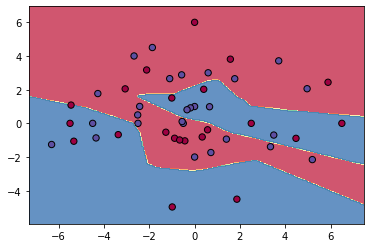

---------- Epoch: 360 ----------
Accuracy: Training Set  : 60.00%
Accuracy: Validation Set: 40.82%


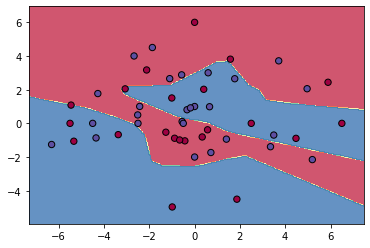

---------- Epoch: 370 ----------
Accuracy: Training Set  : 61.38%
Accuracy: Validation Set: 42.86%


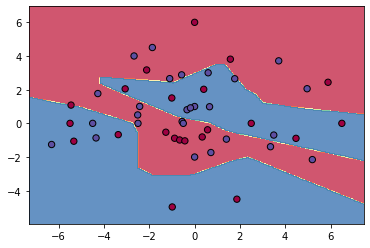

---------- Epoch: 380 ----------
Accuracy: Training Set  : 59.31%
Accuracy: Validation Set: 38.78%


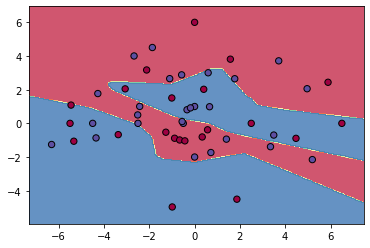

---------- Epoch: 390 ----------
Accuracy: Training Set  : 62.07%
Accuracy: Validation Set: 38.78%


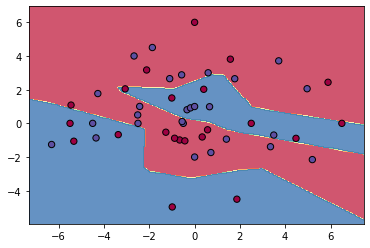

---------- Epoch: 400 ----------
Accuracy: Training Set  : 60.00%
Accuracy: Validation Set: 38.78%


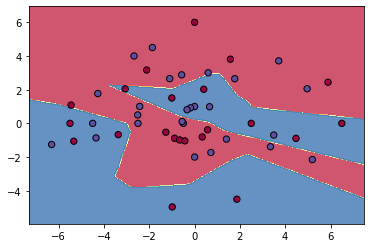

---------- Epoch: 410 ----------
Accuracy: Training Set  : 55.86%
Accuracy: Validation Set: 40.82%


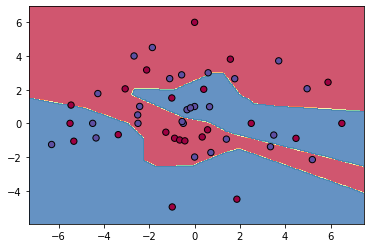

---------- Epoch: 420 ----------
Accuracy: Training Set  : 56.55%
Accuracy: Validation Set: 40.82%


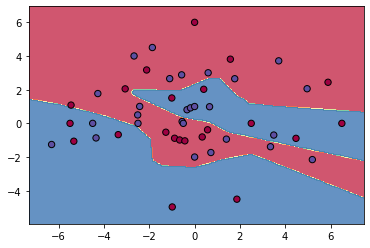

---------- Epoch: 430 ----------
Accuracy: Training Set  : 64.14%
Accuracy: Validation Set: 42.86%


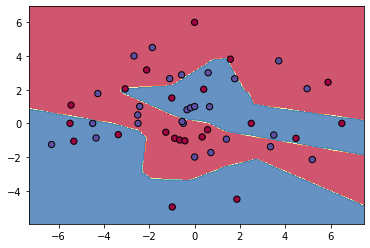

---------- Epoch: 440 ----------
Accuracy: Training Set  : 58.62%
Accuracy: Validation Set: 40.82%


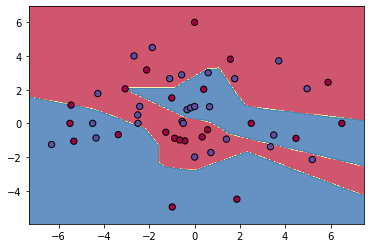

---------- Epoch: 450 ----------
Accuracy: Training Set  : 62.07%
Accuracy: Validation Set: 40.82%


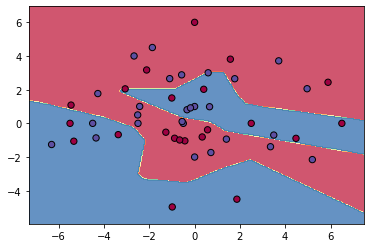

---------- Epoch: 460 ----------
Accuracy: Training Set  : 56.55%
Accuracy: Validation Set: 38.78%


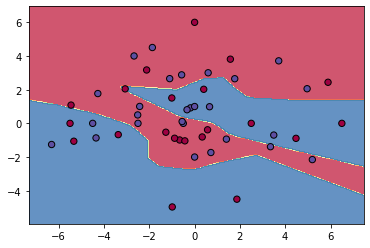

---------- Epoch: 470 ----------
Accuracy: Training Set  : 61.38%
Accuracy: Validation Set: 40.82%


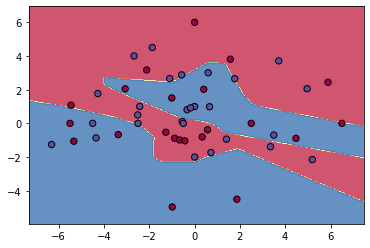

---------- Epoch: 480 ----------
Accuracy: Training Set  : 58.62%
Accuracy: Validation Set: 38.78%


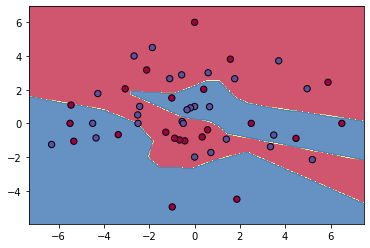

---------- Epoch: 490 ----------
Accuracy: Training Set  : 58.62%
Accuracy: Validation Set: 40.82%


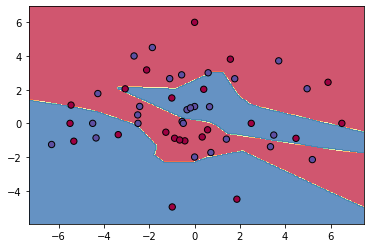

---------- Epoch: 500 ----------
Accuracy: Training Set  : 60.69%
Accuracy: Validation Set: 42.86%


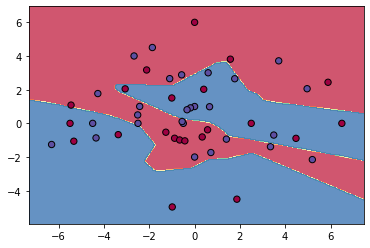

---------- Epoch: 510 ----------
Accuracy: Training Set  : 62.76%
Accuracy: Validation Set: 42.86%


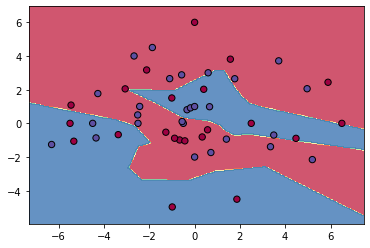

---------- Epoch: 520 ----------
Accuracy: Training Set  : 70.34%
Accuracy: Validation Set: 46.94%


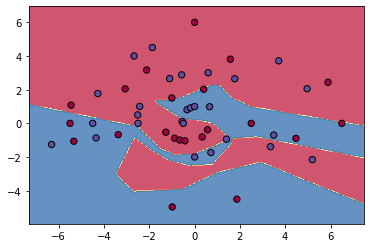

---------- Epoch: 530 ----------
Accuracy: Training Set  : 71.03%
Accuracy: Validation Set: 46.94%


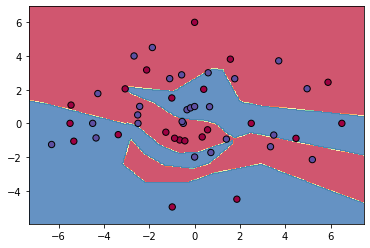

---------- Epoch: 540 ----------
Accuracy: Training Set  : 64.83%
Accuracy: Validation Set: 48.98%


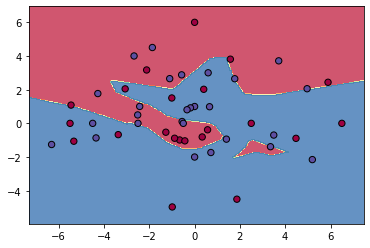

---------- Epoch: 550 ----------
Accuracy: Training Set  : 67.59%
Accuracy: Validation Set: 51.02%


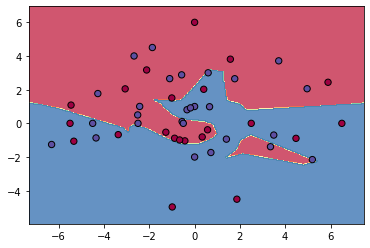

---------- Epoch: 560 ----------
Accuracy: Training Set  : 77.24%
Accuracy: Validation Set: 53.06%


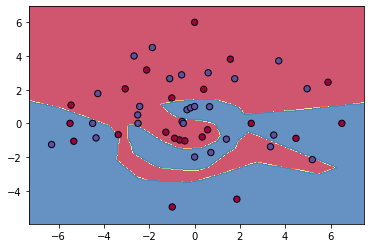

---------- Epoch: 570 ----------
Accuracy: Training Set  : 70.34%
Accuracy: Validation Set: 48.98%


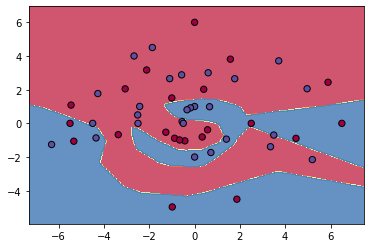

---------- Epoch: 580 ----------
Accuracy: Training Set  : 71.03%
Accuracy: Validation Set: 51.02%


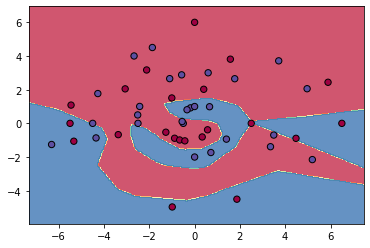

---------- Epoch: 590 ----------
Accuracy: Training Set  : 71.03%
Accuracy: Validation Set: 55.10%


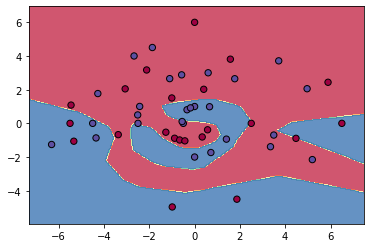

---------- Epoch: 600 ----------
Accuracy: Training Set  : 72.41%
Accuracy: Validation Set: 53.06%


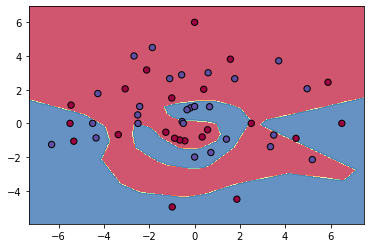

---------- Epoch: 610 ----------
Accuracy: Training Set  : 73.79%
Accuracy: Validation Set: 53.06%


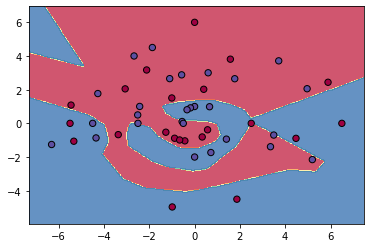

---------- Epoch: 620 ----------
Accuracy: Training Set  : 77.24%
Accuracy: Validation Set: 53.06%


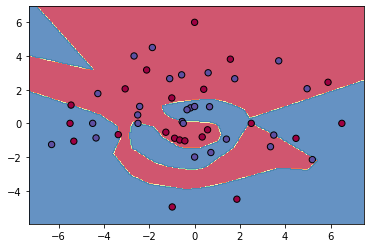

---------- Epoch: 630 ----------
Accuracy: Training Set  : 72.41%
Accuracy: Validation Set: 53.06%


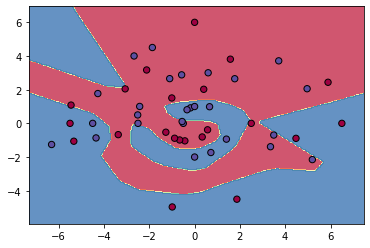

---------- Epoch: 640 ----------
Accuracy: Training Set  : 71.72%
Accuracy: Validation Set: 53.06%


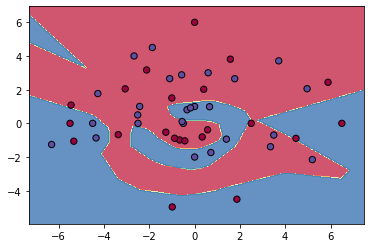

---------- Epoch: 650 ----------
Accuracy: Training Set  : 74.48%
Accuracy: Validation Set: 55.10%


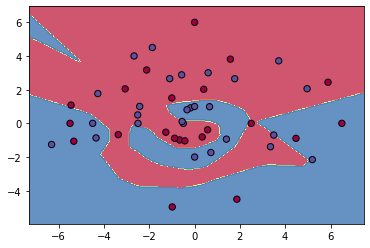

---------- Epoch: 660 ----------
Accuracy: Training Set  : 71.03%
Accuracy: Validation Set: 51.02%


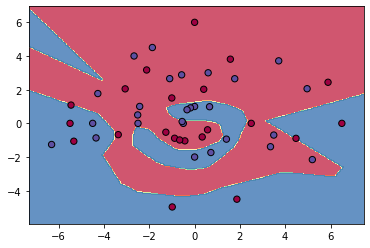

---------- Epoch: 670 ----------
Accuracy: Training Set  : 72.41%
Accuracy: Validation Set: 53.06%


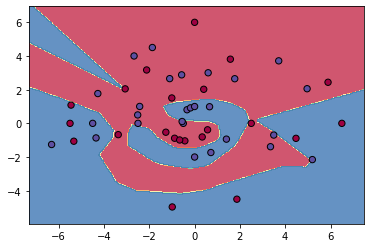

---------- Epoch: 680 ----------
Accuracy: Training Set  : 76.55%
Accuracy: Validation Set: 51.02%


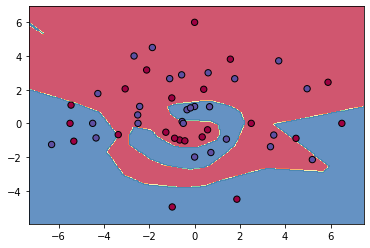

---------- Epoch: 690 ----------
Accuracy: Training Set  : 73.10%
Accuracy: Validation Set: 53.06%


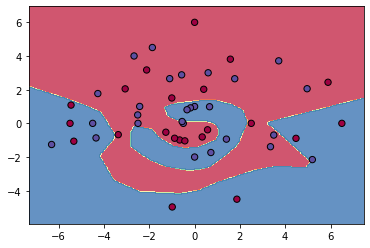

---------- Epoch: 700 ----------
Accuracy: Training Set  : 73.79%
Accuracy: Validation Set: 53.06%


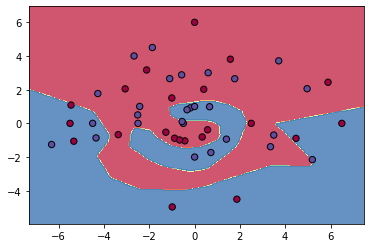

---------- Epoch: 710 ----------
Accuracy: Training Set  : 72.41%
Accuracy: Validation Set: 51.02%


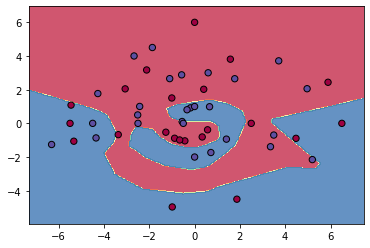

---------- Epoch: 720 ----------
Accuracy: Training Set  : 70.34%
Accuracy: Validation Set: 53.06%


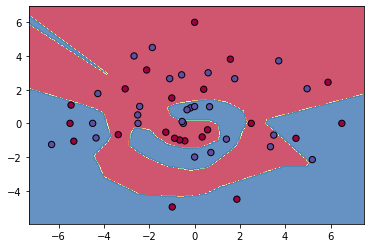

---------- Epoch: 730 ----------
Accuracy: Training Set  : 76.55%
Accuracy: Validation Set: 51.02%


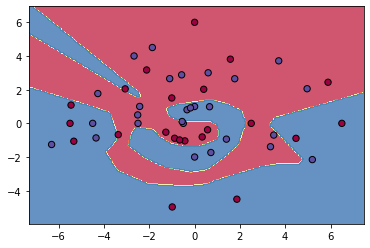

---------- Epoch: 740 ----------
Accuracy: Training Set  : 74.48%
Accuracy: Validation Set: 51.02%


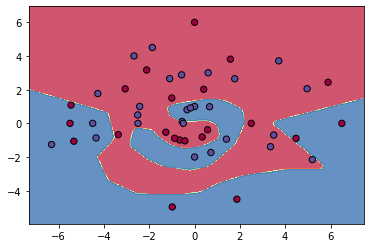

---------- Epoch: 750 ----------
Accuracy: Training Set  : 75.86%
Accuracy: Validation Set: 51.02%


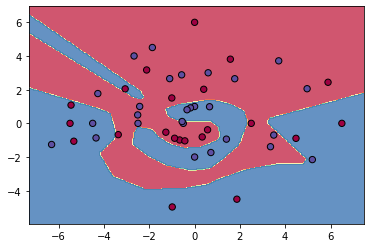

---------- Epoch: 760 ----------
Accuracy: Training Set  : 72.41%
Accuracy: Validation Set: 51.02%


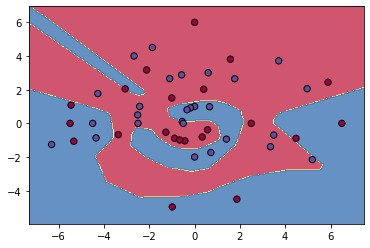

---------- Epoch: 770 ----------
Accuracy: Training Set  : 73.10%
Accuracy: Validation Set: 46.94%


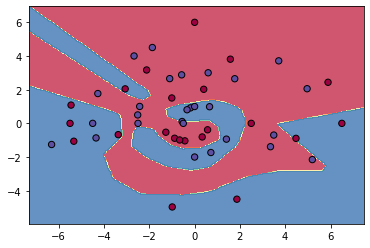

---------- Epoch: 780 ----------
Accuracy: Training Set  : 74.48%
Accuracy: Validation Set: 48.98%


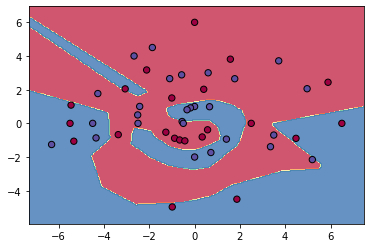

---------- Epoch: 790 ----------
Accuracy: Training Set  : 75.17%
Accuracy: Validation Set: 51.02%


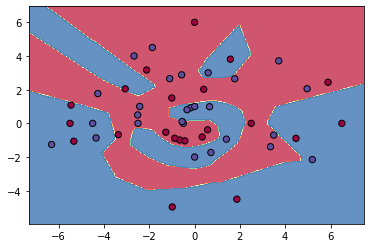

---------- Epoch: 800 ----------
Accuracy: Training Set  : 77.93%
Accuracy: Validation Set: 53.06%


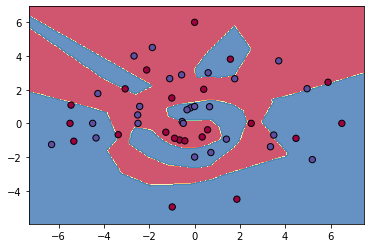

---------- Epoch: 810 ----------
Accuracy: Training Set  : 73.79%
Accuracy: Validation Set: 51.02%


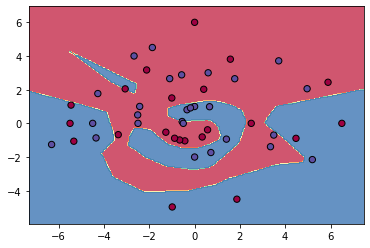

---------- Epoch: 820 ----------
Accuracy: Training Set  : 75.17%
Accuracy: Validation Set: 55.10%


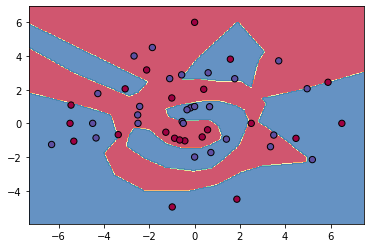

---------- Epoch: 830 ----------
Accuracy: Training Set  : 73.79%
Accuracy: Validation Set: 55.10%


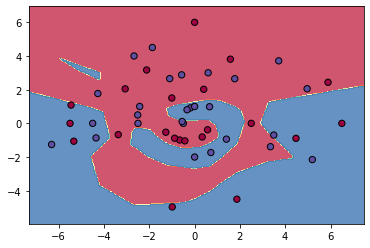

---------- Epoch: 840 ----------
Accuracy: Training Set  : 73.10%
Accuracy: Validation Set: 51.02%


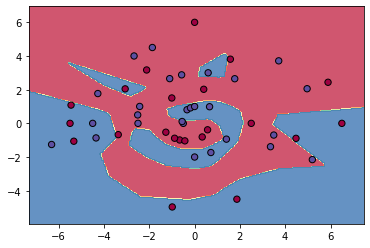

---------- Epoch: 850 ----------
Accuracy: Training Set  : 76.55%
Accuracy: Validation Set: 53.06%


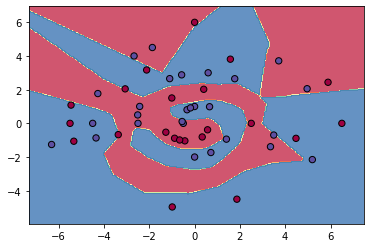

---------- Epoch: 860 ----------
Accuracy: Training Set  : 75.17%
Accuracy: Validation Set: 51.02%


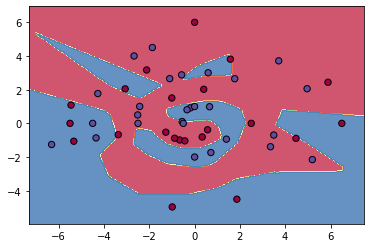

---------- Epoch: 870 ----------
Accuracy: Training Set  : 75.86%
Accuracy: Validation Set: 53.06%


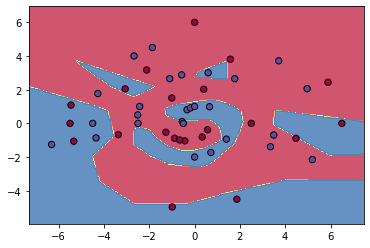

---------- Epoch: 880 ----------
Accuracy: Training Set  : 78.62%
Accuracy: Validation Set: 55.10%


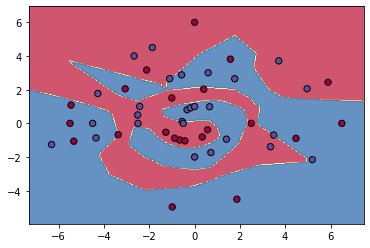

---------- Epoch: 890 ----------
Accuracy: Training Set  : 75.86%
Accuracy: Validation Set: 53.06%


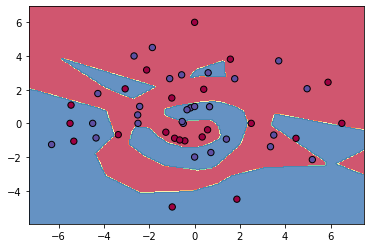

---------- Epoch: 900 ----------
Accuracy: Training Set  : 73.79%
Accuracy: Validation Set: 57.14%


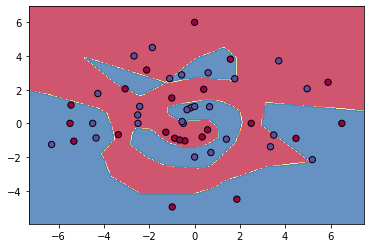

---------- Epoch: 910 ----------
Accuracy: Training Set  : 78.62%
Accuracy: Validation Set: 53.06%


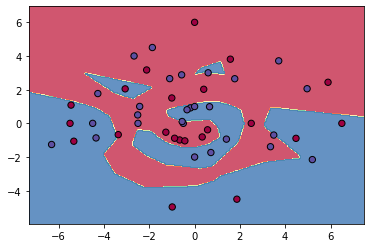

---------- Epoch: 920 ----------
Accuracy: Training Set  : 75.86%
Accuracy: Validation Set: 55.10%


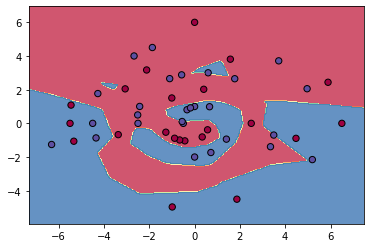

---------- Epoch: 930 ----------
Accuracy: Training Set  : 75.86%
Accuracy: Validation Set: 55.10%


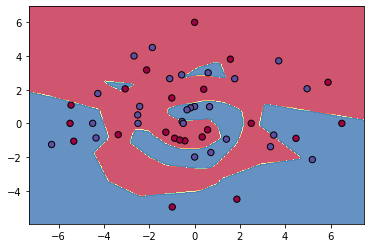

---------- Epoch: 940 ----------
Accuracy: Training Set  : 76.55%
Accuracy: Validation Set: 57.14%


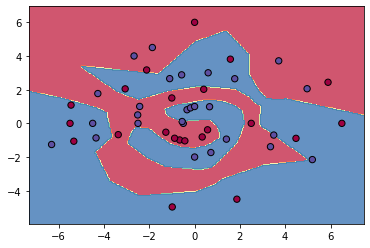

---------- Epoch: 950 ----------
Accuracy: Training Set  : 73.79%
Accuracy: Validation Set: 57.14%


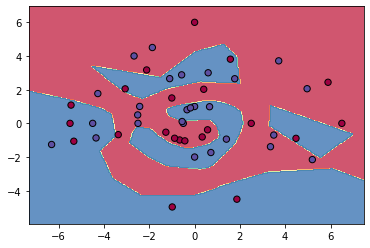

---------- Epoch: 960 ----------
Accuracy: Training Set  : 75.86%
Accuracy: Validation Set: 55.10%


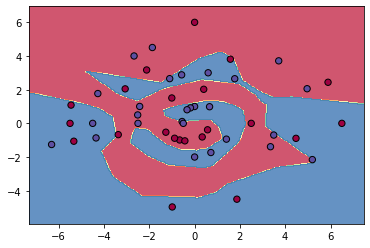

---------- Epoch: 970 ----------
Accuracy: Training Set  : 78.62%
Accuracy: Validation Set: 55.10%


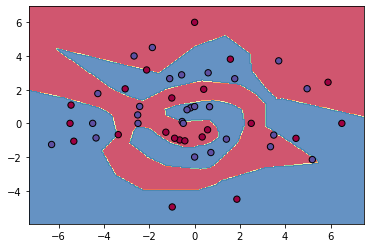

---------- Epoch: 980 ----------
Accuracy: Training Set  : 76.55%
Accuracy: Validation Set: 53.06%


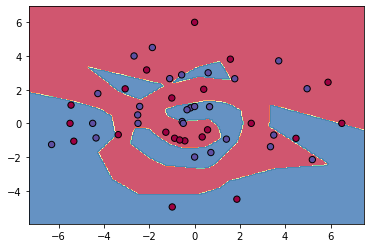

---------- Epoch: 990 ----------
Accuracy: Training Set  : 77.93%
Accuracy: Validation Set: 59.18%


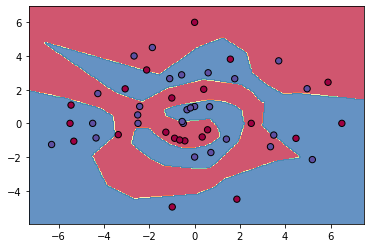

---------- Epoch: 1000 ----------
Accuracy: Training Set  : 75.86%
Accuracy: Validation Set: 51.02%


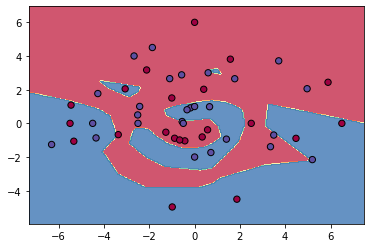

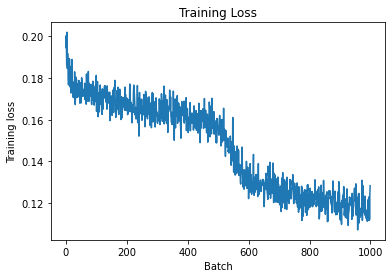

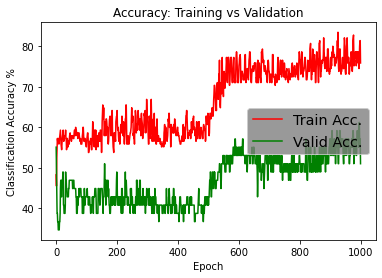

---------- Full Data Set: 194 samples ----------
Accuracy: Full Set  : 69.59%


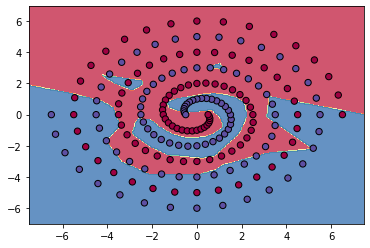

Number of seconds elapsed since the epoch are :  1620385195.307109


In [27]:
# Lists to gather training metrics
train_loss = []
train_acc = []
valid_acc = []


# CUDA for PyTorch
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 194,
          'shuffle': True,
          'num_workers': 0 }

# Train for ...
max_epochs = 1000

# Generators
training_set = Dataset(partition['train'], labels)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'], labels)
validation_generator = data.DataLoader(validation_set, **params)

# Loop over epochs
for epoch in range(max_epochs):
    # Training
    for X_train, y_train in training_generator:
        # Transfer to GPU
        X_train, y_train = X_train.to(device), y_train.to(device)
                       
        #Set to training mode
        model.train()      
           
        # Model computations
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(X_train)

        # Compute and print loss.
        loss = loss_fn(y_pred, y_train)       

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
        # Collect the training loss value for plotting
        train_loss.append(loss.item())        
             
    # Validation at the end of each epoch
    with torch.set_grad_enabled(False):
      # Lists to gather training metrics for this batch
      batch_ta = []
      batch_va = []
      for X_valid, y_valid in validation_generator:
          #Transfer to GPU
          X_valid, y_valid = X_valid, y_valid
          
          # Training set accuracy
          ta = check_accuracy(model, X_train, y_train)
          batch_ta.append(ta)
                    
          # Validation set accuracy
          va = check_accuracy(model, X_valid, y_valid)
          batch_va.append(va)
          
      train_acc.append(np.mean(ta))  
      valid_acc.append(np.mean(va))
      
    if (epoch + 1) % 10 == 0:
      print('---------- Epoch: {} ----------'.format(epoch + 1))
      print('Accuracy: Training Set  : {:.2f}%'.format(train_acc[-1]))           
      print('Accuracy: Validation Set: {:.2f}%'.format(valid_acc[-1]))
      # Decode the one-hot encoding e.g: [0,1,0] back to numerical values; 1
      (y_max_vals, y_arg_maxs) = torch.max(y_valid.data, dim=1)
      # Plot batch on decision boundaries so far learned
      plot_decision_boundary(model, X_valid.cpu(), y_arg_maxs.cpu())  
                
# Loss plot
fig, ax = plt.subplots()
ax.plot(train_loss)
ax.set_xlabel('Batch')
ax.set_ylabel('Training loss')
ax.set_title('Training Loss')
plt.show()

# Accuracy plot
fig1, ax1 = plt.subplots()
ax1.plot(train_acc, 'r-', label='Train Acc.')
ax1.plot(valid_acc, 'g-', label='Valid Acc.')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Classification Accuracy %')
ax1.set_title('Accuracy: Training vs Validation')
legend1 = ax1.legend(loc='center right', shadow=False, fontsize='x-large')
# Set legend background colour
legend1.get_frame().set_facecolor('0.5')
plt.show()


# Plot full data set overlayed on learned decision boundaries
print('---------- Full Data Set: {} samples ----------'.format(len(x)))
# Original data is not ohe
y_one_hot = np.eye(3)[y[:,0]]
print('Accuracy: Full Set  : {:.2f}%'.format(check_accuracy(model, torch.tensor(x, dtype=torch.float32),
    torch.tensor(y_one_hot, dtype=torch.float32))))
plot_decision_boundary(model, x, y)

print("Number of seconds elapsed since the epoch are : ", time.time())